# Implementing Modern Geophysical Data Analysis and Visualisation Techniques for Accurate Gap Prediction, log Interpretation and Intervention to Prevent Catastrophes 

# Abstract 
Well log data collected in the field often include gaps and out of range readings, which means data include missing values and outliers for many reasons, for instance due to noise. This makes it hard to rely on it for the interpretation of lithological properties and detect failures. To address the gaps and out of range data issue, I present and compare different gap filling and visualization algorithms. The proposed methods predict missing values in each measurement separately based on data points around missing values in the same well log. The algorithms were applied on a LAS data file from BAUMAN #3 in Kansas. The data file used in this work is a free dataset provided by the University of Kansas. In this study I will be using Python 3 version for coding.


# 1. Introduction

Well data are geophysical measurements acquired along a borehole, providing direct information about the reservoir characterization. These data are collected during any phase of a well history: drilling, completing, producing, or abandoning. The data collected by logging wells can have significant economic consequences, due to the costs inherent to drilling wells, and the potential return of well deposits. The quality of acquired data, as well as data processing and interpretation techniques, are crucial for taking drilling/production decisions and eliminating catastrophes. 
The objective of this work is to develop a well log data processing, data cleaning, analysis and interpretation model to have a precise understanding of the well geological properties and test the functionality of the measurement tools. In this study, I will focus on data cleaning, gap filling and visualization methods based on the collected data from the same well. 
The first section will explain a method for reading Log ASCII Standard (LAS) files and the required libraries. The second section covers data cleaning, predicting missing data using different approaches. The last section will cover data visualization and interpretation aspects.

# 2. Reading LAS file

Log ASCII Standard (LAS) file is the most commonly used format to store well log data. Since LAS files cannot be read by the common libraries in python such as Numpy and Pandas, a special library should be used for this purpose. The most commonly used libraries for reading LAS files in Python are: libLAS, laspy and lasio.

**Install lasio**





In [ ]:
!pip install lasio
!pip install -r optional-packages.txt
!pip install --upgrade lasio
!pip install missingno

**Import Libraries:**

In [2]:
import pandas as pd
import numpy as np
import lasio
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
% matplotlib inline

**Read LAS file:**

In [3]:
las = lasio.read(r'1051661161.las')

**Checking the header description:**

Using this command, we get basic information about our data such as units and number of data points in the file.

In [ ]:
las.curves

**Coverting data into a data frame:**

For the sake of this study and to be able to apply Data Science main libraries we have studied during the Data Science II course, I will convert our data to a data frame.

In [5]:
df = las.df()

**Header check**

In [ ]:
df.head()

**Tailer check**

In [ ]:
df.tail()

**Checking the description**

In [ ]:
df.describe()

In [ ]:
df.columns

# 3. Data cleaning
Since out of range and null values are inevitable in well logs, developing precise and practical solutions to overcome these issues is crucial to ensure the credibility of the collected data. From my own experience, the most common technique to solve these issues is to eliminate the line of measurements source of the problem, which I think is inappropriate since it affects the data resolution, implies the risk of eliminating vital data, and increase the  risk of well catastrophes such as: missing the targeted zone, reaching an unexpected formation amateurly during the drilling practice.
The objectives of this section are:
*   Use a data cleaning algorithm for data filtering to eliminate outliers.
*   Develop and compare different techniques to predict missing data using data from the same well.


# 3.1 Cleaning Outliers
Measurement normalization identifies and removes systematic errors from well log data so that reliable results may be obtained for reservoir evaluation, solving difficult correlation and seismic modeling problems. For that, plenty of techniques and algorithms were developed to provide accurate data normalization, most of which use machine learning models to correlate data from different adjacent wells at the same reservoir. However, in this section, I will introduce a simple technique to convert outliers to NaN values and leave it to be processed as missing data in the next section.
The lithological properties of different formations have a normal range. The readings out of that range should not be accounted for. The normal range of essential measurements is described in the following table:

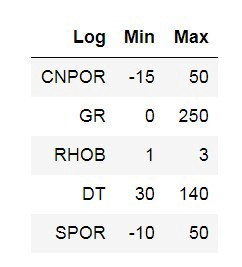

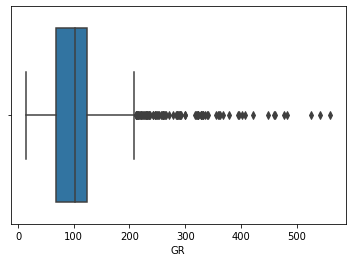

In [6]:
# Boxplot shows GR readings range (normal range is 0 - 250)
sns.boxplot( x= 'GR', data = df)

**Removing outliers:**

In [ ]:
# Before
df.describe()

The following method is commonly used in the field to eliminate outliers. As we can see, even though this method eliminates outliers, it completely removes of the whole line of measurement containing outliers and eventually reduces the density and quality of our measurements.

In [ ]:
# Method 1: Filter out outliers (Old method used in the field)
df_clean_outliers = df[(df.CNPOR > -15)&(df.CNPOR <= 50)]
df_clean_outliers = df_clean_outliers[(df_clean_outliers.GR > 0) & (df_clean_outliers.GR  <= 250)]
df_clean_outliers = df_clean_outliers[(df_clean_outliers.RHOB> 1) & (df_clean_outliers.RHOB<= 3)]
df_clean_outliers = df_clean_outliers[(df_clean_outliers.DT > 30) & (df_clean_outliers.DT <= 140)]
df_clean_outliers = df_clean_outliers[(df_clean_outliers.SPOR > -10) & (df_clean_outliers.SPOR <= 50)]
df_clean_outliers.describe()

In the following method, outliers are converted into  null values. This way, we guarantee eliminating outliers and maintain the density of our measurements which results a remarkable impact on the quality. 

In [ ]:
# Method 2: convert outliers to NaN values

def clean_outliers(data):
  for x in data['CNPOR']:
    if  x < -15 or x > 50:
      data['CNPOR'] = data['CNPOR'].replace(x, np.nan)
  
  for x in data['GR']:
    if  x < 0 or x > 250:
      data['GR'] = data['GR'].replace(x, np.nan)

  for x in data['RHOB']:
    if  x < 1 or x > 3:
      data['RHOB'] = data['RHOB'].replace(x, np.nan)
  
  for x in data['DT']:
    if  x < 30 or x > 140:
      data['DT'] = data['DT'].replace(x, np.nan)
  
  for x in data['SPOR']:
    if  x < -10 or x > 50:
      data['SPOR'] = data['SPOR'].replace(x, np.nan)
  for x in data['RILM']:
    if  x  > 1000:
      data['RILM'] = data['RILM'].replace(x, np.nan)
  for x in data['RILD']:
    if  x  > 1000:
      data['RILD'] = data['RILD'].replace(x, np.nan)
  for x in data['RLL3']:
    if  x  > 1000:
      data['RLL3'] = data['RLL3'].replace(x, np.nan)
  return data

df = clean_outliers(df)
df.isna().sum()

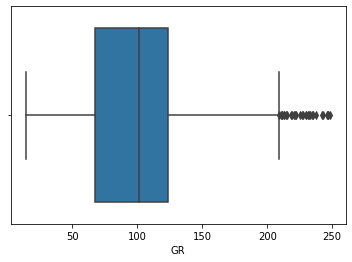

In [9]:
# Boxplot shows GR readings range after removing outliers (normal range is 0 - 250)
sns.boxplot( x= 'GR', data = df)

# 3.2 Handling missing values

Well lithological properties are random and aperiodic and rely on factors such as mineral composition, lithology, porosity, cementation, compaction, presence of fluids, etc. Null values in Well data are very common issues. Measurement data can contain a non zero amount of missing values for plenty of reasons. This eventually leads to a great impact on the quality of our data, so do repair methods. Thus, based on the essence of measurement gaps, we should be critical when we decide which, where and how the reading gap should be handled. For example: we should consider the sensor offset, size of the gap, and whether the gap interval is logged or not. The common methods for handling missing values in the field are: relogging the gap interval or simply getting rid of it. In this section, I will introduce five methods for handling missing data and compare the impact of each method on the quality of our data.

In [ ]:
df.isna().sum()

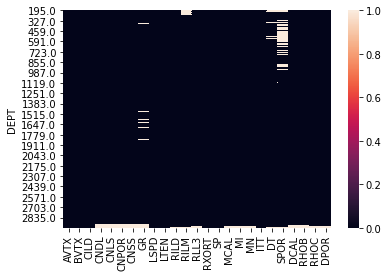

In [10]:
# A plot shows missing values
sns.heatmap(df.isnull(), cbar=True)
#msno.matrix(df)

**3.2.1 Eliminating null values**

Although it's apparent inefficiency and dangers, getting rid of the missing data is still a very common method. This method reduces the quality of our model as it reduces sample size because it deletes all other observations where data are missing. The higher the amount of missing data, the greater the risk of using this method.

In [11]:
# Drop rows of missing data
df_eliminate_na = df.dropna(axis=0, how='any')
df_eliminate_na.isna().sum().sum()

0

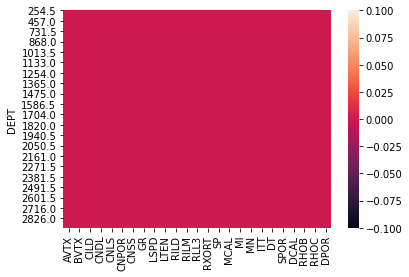

In [12]:
#msno.matrix(df_eliminate_na)
sns.heatmap(df_eliminate_na.isnull(), cbar=True)

**3.2.2 Replace missing values with mean using Univariate feature imputation**

This method provides a basic strategy for imputing missing values. Missing values are imputed using statistical mean of each column in which missing values are located. This method lacks accuracy since it replaces all missing values using one value neither taking into consideration the change in formation properties nor unlogged intervals and sensors offsets.

In [13]:
df_Simple_impute = df
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_Simple_impute)
SimpleImputer(missing_values=np.nan)
X_test = df_Simple_impute
df_Simple_impute = pd.DataFrame(imp.transform(X_test), columns = [ 'AVTX', 'BVTX', 'CILD', 'CNDL', 'CNLS', 'CNPOR', 'CNSS', 'GR', 'LSPD',
       'LTEN', 'RILD', 'RILM', 'RLL3', 'RXORT', 'SP', 'MCAL', 'MI', 'MN',
       'ITT', 'DT', 'SPOR', 'DCAL', 'RHOB', 'RHOC', 'DPOR'])

df_Simple_impute['Depth'] = df.index
df_Simple_impute.set_index(df.index, inplace=True)

df_Simple_impute.isna().sum().sum()

0

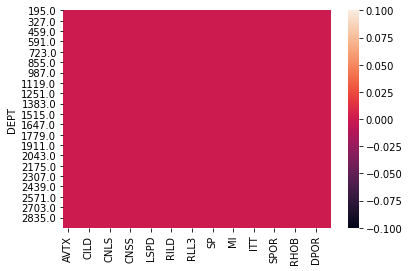

In [14]:
#msno.matrix(df_Simple_impute)
sns.heatmap(df_Simple_impute.isnull(), cbar=True)

**3.2.3 Impute Missing Values using Interpolation Method**

Imputation fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely. Since well logs are continuous data with reference to depth, often the average of previous and next values gives a better estimate of the missing value. This method is efficient in avoiding missing data on top and the bottom of the well log since this gap has to do with the sensor offset, and the interval from / to which the measurement tool is used.

In [15]:
mask = df.interpolate(axis=0, limit_area='inside', limit=6, limit_direction='backward').isna()
df_imput_interpol = df.interpolate(axis=0, limit_area='inside', limit=6).mask(mask)
df_imput_interpol.isna().sum().sum()

1618

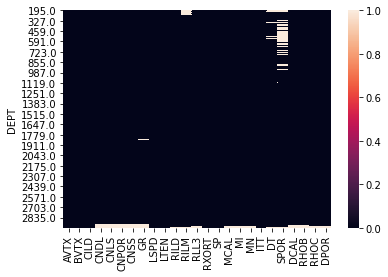

In [16]:
#msno.matrix(df_imput_mean)
sns.heatmap(df_imput_interpol.isnull(), cbar=True)

**3.2.4 K-nearest-neighbour Imputation**

In this method, missing values are imputed based on the K-nearest-neighbour algorithm. With this algorithm, missing values are replaced by the nearest neighbor estimated values. This method weights samples using the mean squared difference on features for which two rows both have observed data. This method is efficient in predicting gaps inside the log data, on the other hand, it has proven its insufficiency in detecting and avoiding unlogged intervals such as the log top and bottom readings. A manual correction can be used to solve this issue. However, this interferes with the sole purpose of this study.

In [17]:
impute_KNN_train = df
lis = []
for i in range(0, impute_KNN_train.shape[1]):
     
    if(impute_KNN_train.iloc[:,i].dtypes == 'object'):
        impute_KNN_train.iloc[:,i] = pd.Categorical(impute_KNN_train.iloc[:,i])
        impute_KNN_train.iloc[:,i] = impute_KNN_train.iloc[:,i].cat.codes 
        impute_KNN_train.iloc[:,i] = impute_KNN_train.iloc[:,i].astype('object')
         
        lis.append(impute_KNN_train.columns[i])

impute_KNN_train = pd.DataFrame(KNNImputer(n_neighbors = 4).fit_transform(impute_KNN_train), columns = impute_KNN_train.columns)
impute_KNN_train
imputer = KNNImputer(n_neighbors=4, weights="uniform")

df_imput_KNN = imputer.fit_transform(df)
df_imput_KNN = pd.DataFrame(df_imput_KNN, columns = [ 'AVTX', 'BVTX', 'CILD', 'CNDL', 'CNLS', 'CNPOR', 'CNSS', 'GR', 'LSPD',
       'LTEN', 'RILD', 'RILM', 'RLL3', 'RXORT', 'SP', 'MCAL', 'MI', 'MN',
       'ITT', 'DT', 'SPOR', 'DCAL', 'RHOB', 'RHOC', 'DPOR'])

df_imput_KNN['Depth'] = df.index
df_imput_KNN.set_index(df.index, inplace=True)

df_imput_KNN.isna().sum().sum()

0

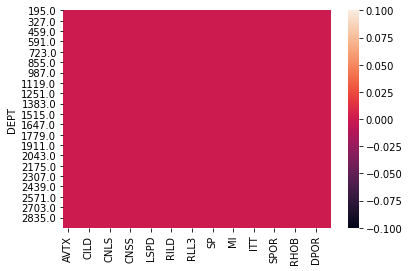

In [18]:
#msno.matrix(df_imput_KNN)
sns.heatmap(df_imput_KNN.isnull(), cbar=True)

**3.2.5 Nearest Neighbors Regression**

Neighbors-based regression is a practical imputation method when data labels are continuous rather than discrete variables, which is the case in well log data. Nearest neighbors regression uses uniform weights thereby, each point in the local neighborhood contributes uniformly to the classification of a query point. However, this method is advantageous to weight points such that nearby points contribute more to the regression than distant points. Nevertheless, NNR method is inefficient in avoiding missing data on top and the bottom of the well log.


In [19]:
def impute_model_progressive(df):
  cols_nan = df.columns[df.isna().any()].tolist()
  cols_no_nan = df.columns.difference(cols_nan).values
  while len(cols_nan)>0:
      col = cols_nan[0]
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=4).fit(train_data[cols_no_nan], train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
      cols_nan = df.columns[df.isna().any()].tolist()
      cols_no_nan = df.columns.difference(cols_nan).values
  return df

df_imput_progressive = impute_model_progressive(df)
df_imput_progressive.isna().sum().sum()

0

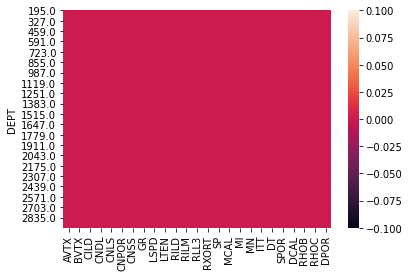

In [20]:
#msno.matrix(df_imput_progressive)
sns.heatmap(df_imput_progressive.isnull(), cbar=True)

# 3.3 Comparison between different gap filling methods

In this section, I will compare the different gap-filling techniques introduced earlier taking an example of Gamma-Ray log since it implies  plenty of gaps and it's the most frequently used measurement in detecting formation features. 
As we can observe in the graph below, eliminating null values method has an unignorable impact on the quality of our data. Not only that, it also eliminates plenty of good readings present at the same row together will null values. 
Having a look at heatmaps below each technique, we realise that imputing missing values using the interpolation method has succeeded in detecting and avoiding gaps occured due to reading start depth and sensor offset on top and bottom of the log. It also gave us an accurate prediction of the missed values. Even though the other methods gave almost the same accurate prediction results, these methods failed in avoiding gaps at the top and bottom of the log. However, this problem could be solved manually by determining the interval of interest, but this will interfere with the sole purpose of this study in empowering automation to save time, provide accurate solutions and avoid human errors.

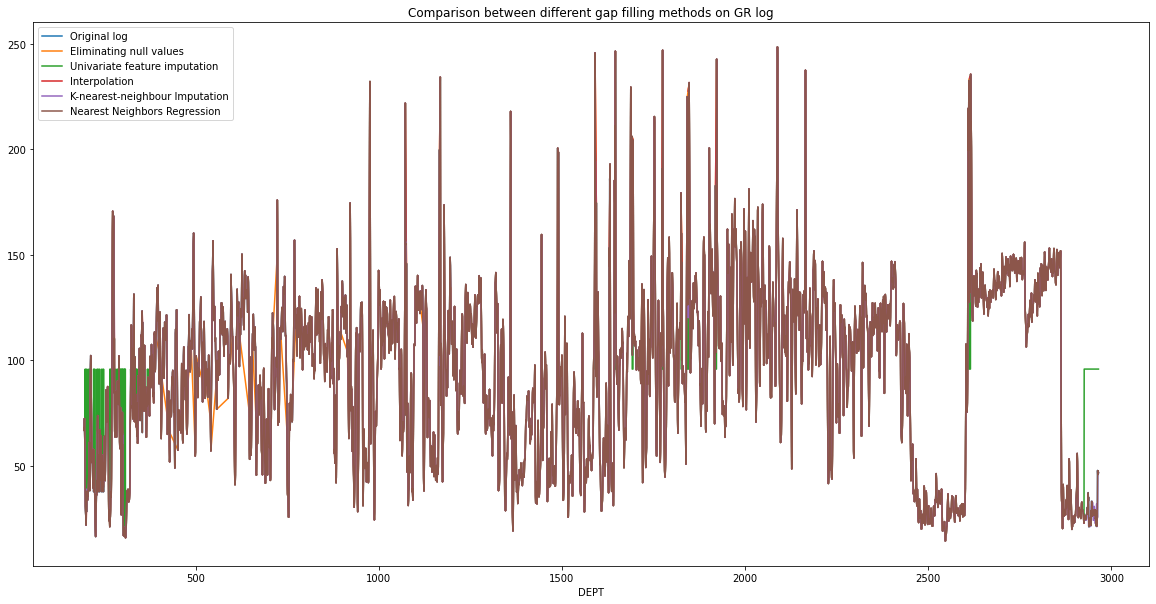

In [21]:
df['GR'].plot( figsize=(20, 10), label = 'Original log')
df_eliminate_na['GR'].plot( figsize=(20, 10) , label = 'Eliminating null values')
df_Simple_impute['GR'].plot( figsize=(20, 10), label = 'Univariate feature imputation')
df_imput_interpol['GR'].plot(figsize=(20, 10) , label = 'Interpolation')
df_imput_KNN['GR'].plot(figsize=(20, 10), label = 'K-nearest-neighbour Imputation')
df_imput_progressive['GR'].plot( figsize=(20, 10), label = 'Nearest Neighbors Regression')
plt.title('Comparison between different gap filling methods on GR log')
plt.legend()



# 4. Data Visualisation and Interpretation

In this section, I will introduce different data visualisation techniques to check the quality of our measurements, detect sensor failures, offer a better interpretation of formation lithologies and formation fluids.

# 4.1 Quality Check and failure detection

In this section I will group readings of the same measurement from different sensors together and see if the readings have the same trend. This method helps us to check the occuracy of measurement's applied correction models, the functionality and quality of the received readings from different sensors and detect failed sensors.

**Resistivity measurement**

Resistivity logs determine what types of fluids are present in the reservoir
formation by measuring how effective these rocks are at conducting electricity. Conventional resistivity logs are generated by means of electrodes in contact with the formation through the drilling mud. Several sensors are capable of measuring formation resistivity in different distances (Short Normal (RLL3), medium Normal (RILM) and deep (RILD)). Comparing different resistivity logs gives us an indication about the validity of our correction models and sensor's functionality.
The log below shows that resistivity readings from different sensors have the same trend, which means all sensors are functioning well and the correction model is accurate.

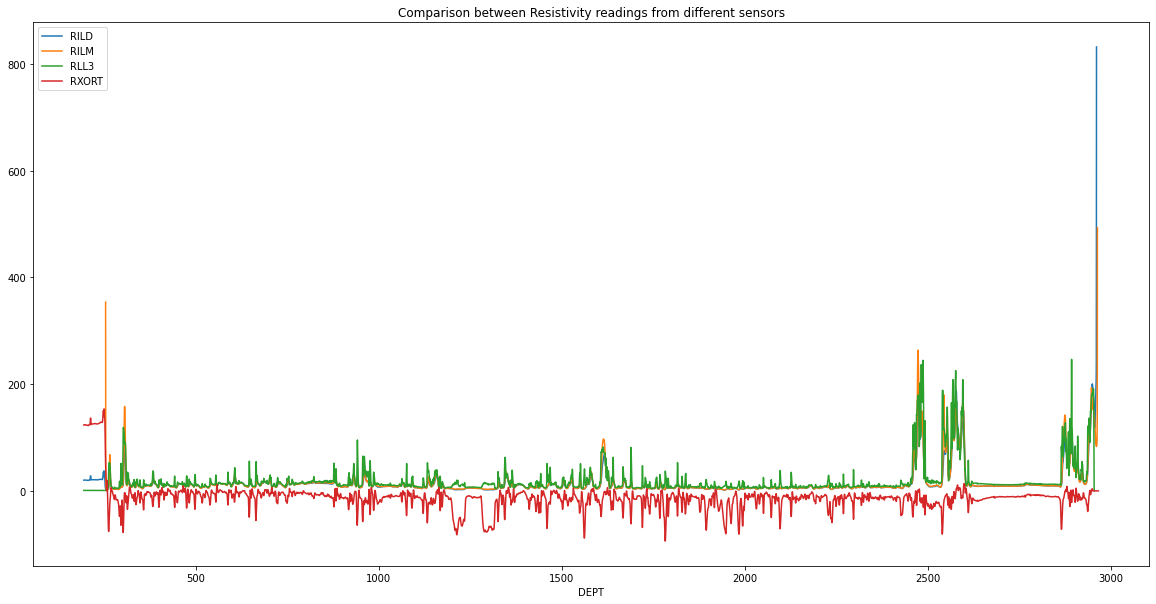

In [22]:
df_imput_interpol['RILD'].plot(figsize=(20, 10) , label = 'RILD')
df_imput_interpol['RILM'].plot(figsize=(20, 10) , label = 'RILM')
df_imput_interpol['RLL3'].plot(figsize=(20, 10) , label = 'RLL3')
df_imput_interpol['RXORT'].plot(figsize=(20, 10) , label = 'RXORT')

plt.title('Comparison between Resistivity readings from different sensors')
plt.legend()


****

In [23]:
df_imput_interpol.columns

Index(['AVTX', 'BVTX', 'CILD', 'CNDL', 'CNLS', 'CNPOR', 'CNSS', 'GR', 'LSPD',
       'LTEN', 'RILD', 'RILM', 'RLL3', 'RXORT', 'SP', 'MCAL', 'MI', 'MN',
       'ITT', 'DT', 'SPOR', 'DCAL', 'RHOB', 'RHOC', 'DPOR'],
      dtype='object')

**Porosity measurement**

Porosity logs work by bombarding a formation with high energy epithermal neutrons that lose energy through elastic scattering to near thermal levels before being absorbed by the nuclei of the formation atoms. In the following log, we can observe that different porosity logs have the same trend which indicates the functionality of the correction model used in this well.

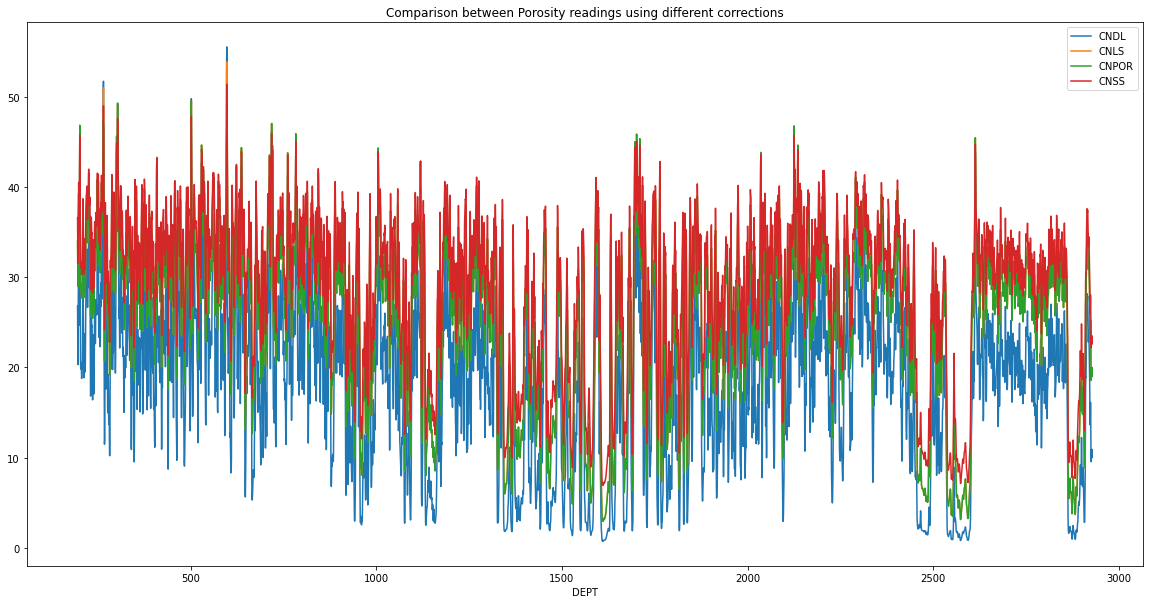

In [24]:
df_imput_interpol['CNDL'].plot(figsize=(20, 10) , label = 'CNDL')
df_imput_interpol['CNLS'].plot(figsize=(20, 10) , label = 'CNLS')
df_imput_interpol['CNPOR'].plot(figsize=(20, 10) , label = 'CNPOR')
df_imput_interpol['CNSS'].plot(figsize=(20, 10) , label = 'CNSS')
plt.title('Comparison between Porosity readings using different corrections')
plt.legend()

# 4.2 Log Interpretation

Different log data show different formation properties. Gamma-ray and Poisson’s ratio are excellent lithology indicators, while others like Density and P-wave velocity logs are useful for understanding the rock type, types of pore fluids as well as the pressure and compaction trends in the deposited sediments. Density porosity, a physical property that is derived from density logs gives a measure of the amount of pore space in the same rock type or different rock-type. 
The log responses with respect to bed boundaries are different for different lithologies. Lower GR, Poisson’s ratio, density, velocity values and higher porosity values are characteristics of clean sands. Shales tend to have higher GR values compared to sand. The porosity is extremely low compared to sands, while density, Poisson’s ratio and velocity values are higher. Claystone has properties in between sand and shale.


In [25]:
df_plot = df_imput_interpol.rename_axis('Depth').reset_index()

In [30]:
def measurement_log(data):
    data = data.sort_values(by='Depth')
    top = data.Depth.min()
    bot = data.Depth.max()
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12,8))
    ax[0].plot(data.GR, data.Depth, color='green')
    ax[1].plot(data.CNPOR, data.Depth, color='red')
    ax[2].plot(data.DT, data.Depth, color='black')
    ax[3].plot(data.MCAL, data.Depth, color='blue')
    ax[4].plot(data.RHOB, data.Depth, color='c')
    ax[5].plot(data.RILM, data.Depth, color='red')
    
        
    for i in range(len(ax)):
        ax[i].set_ylim(top,bot)
        ax[i].invert_yaxis()
        ax[i].grid()
        
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(data.GR.min(),data.GR.max())
    ax[0].set_ylabel("Depth(ft)")
    ax[1].set_xlabel("CNPOR")
    ax[1].set_xlim(data.CNPOR.min(),data.CNPOR.max())
    ax[2].set_xlabel("DT")
    ax[2].set_xlim(data.DT.min(),data.DT.max())
    ax[3].set_xlabel("MCAL")
    ax[3].set_xlim(data.MCAL.min(),data.MCAL.max())
    ax[4].set_xlabel("RHOB")
    ax[4].set_xlim(data.RHOB.min(),data.RHOB.max())
    ax[5].set_xlabel("RILM")
    ax[5].set_xlim(data.RILM.min(),data.RILM.max())
    
    ax[1].set_yticklabels([]) 
    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
    ax[5].set_yticklabels([])
    
    f.suptitle('Well: BAUMAN #3', fontsize=14,y=0.94)

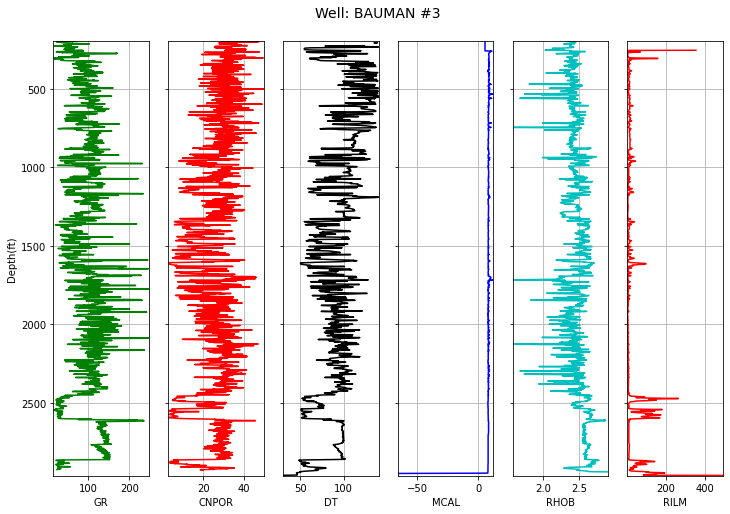

In [31]:
measurement_log(df_plot)

# 5. Conclusion

This study is an attempt to address the most encountered issues in the field of geophysical well log data processing, proposed, explained, and compared different data cleaning, gap filling, quality check and interpretation techniques using data collected from BAUMAN #3 well. The study showed how powerfull and promising Modern data science tools and libraries in the field of well log processing. 


# 6. Future work
In the next work, I will  work on developing and comparing different supervised and unsupervised ML models for gap-filling, detecting and interpreting well lithological properties automatically based on a collective amount of training well log data from the same reservoir. This includes collecting a big amount of logs, analyzing gaps on a log-by-log basis, defining and fine-tuning ML algorithms, cluster samples by log similarity and develop different models for the same well to improve the prediction performance and empower automation in this sector. 